In [150]:
import pandas as pd
import re
from datetime import datetime, timedelta
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [151]:
#определение основных функций

def limits (column):
    iqr = df[column].quantile(0.75) - df[column].quantile(0.25)
    q25 = df[column].quantile(0.25)
    q75 = df[column].quantile(0.75)
    print('25-й квантиль: {},'.format(q25), '75-й квантиль: {},'.format(q75)
      , "IQR: {}, ".format(iqr),"Границы выбросов: [{f}, {l}].".format(f=q25 - 1.5*iqr, l=q75 + 1.5*iqr))

In [152]:
df = pd.read_csv('main_task.csv')
df.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [153]:
# признак, показывающий больше или меньше кол-во кухонь в ресторане по сравнению со средним значением

cuisine_styles = df['Cuisine Style'].str.findall(r'\w+\s*\w*\s*\w*').dropna()
cuisine_styles

sum_list = []

for row in cuisine_styles:
    sum_list.append(len(row))
mean = round((sum(sum_list)+9283)/(len(sum_list)+9283),1)
mean

# 9283 - количество пропущенных значений

def more_then_mean (row):
    if float(len(row)) > mean:
        return 1
    else:
        return 0

In [154]:
df['more_then_mean_cuisines'] = df['Cuisine Style'].str.findall('\w+\s*\w*\s*\w*').fillna(2).apply(lambda x:
                                                                                                      x if x == 2 else
                                                                                                      more_then_mean(x))

In [155]:
# создаем признак количества видов кухон в каждом ресторане

df['Cuisine Style'] = df['Cuisine Style'].apply(lambda x: 'Some kind' if pd.isnull(x) else x)
df['Cuisine Style'] = df['Cuisine Style'].str.findall('\w+\s*\w*\s*\w*')
df['cuisines_amount'] = df['Cuisine Style'].apply(lambda x: len(x))

In [156]:
#создадим признак, показывающий есть ли в ресторане кухня, входящая в топ-10 по популярности

top_10_cuisines_series = df['Cuisine Style'].explode().value_counts(ascending=False).head(11)
top_10_cuisines = list(top_10_cuisines_series.index)
top_10_cuisines.remove('Some kind')
top_10_cuisines

['Vegetarian Friendly',
 'European',
 'Mediterranean',
 'Italian',
 'Vegan Options',
 'Gluten Free Options',
 'Bar',
 'French',
 'Asian',
 'Pizza']

In [157]:
df['Popular Cousine'] = df['Cuisine Style'].apply(lambda x: 1 if any(y in x for y in top_10_cuisines) else 0)

In [160]:
# создадим признак, показывающий разницу между датами отзывов на сайте

def reviews_date(row, number):
    date = re.findall(r'\d\d?/\d\d?/\d+', row)

    if len(date) == 0:
        return np.nan
    if number == 1:
        return pd.to_datetime(date[0])
    elif len(date) == 2:
        return pd.to_datetime(date[1])
    else:
        return np.nan
df['Reviews_first'] = df['Reviews'].apply(lambda x: reviews_date(str(x), 1))
df['Reviews_second'] = df['Reviews'].apply(lambda x: reviews_date(str(x), 2))

In [159]:
df['date_diff'] = abs(df.Reviews_first - df.Reviews_second)
df['date_diff'] = df['date_diff'].apply(lambda x: x.days)
df['date_diff'] = df['date_diff'].apply(lambda x: 0 if np.isnan(x) else x)

In [162]:
# создадим признак, показывающий разницу между сегодняшней датой и датой публикации последнего
# для начала создадим функцию, определяющую самую "свежую" дату отзыва
# затем вычтем из текущей даты и отобразим количество дней до сегодняшнего момента в новый столбец

def max_date(row):
    date = re.findall(r'\d\d?/\d\d?/\d+', row)

    if len(date) == 0:
        return np.nan
    if len(date) == 1:
        return pd.to_datetime(date[0])
    elif len(date) == 2:
        return pd.to_datetime(date).max()
    else:
        return np.nan

In [165]:
df['Last_review'] = df['Reviews'].apply(lambda x: max_date(str(x)))
today = datetime.now()
df['Last_review']

0       2017-12-31
1       2017-07-06
2       2018-01-08
3              NaT
4       2017-11-18
           ...    
39995   2017-12-16
39996   2017-12-21
39997   2016-11-03
39998   2017-07-11
39999   2016-01-31
Name: Last_review, Length: 40000, dtype: datetime64[ns]

In [51]:
df['Scince_last_review'] = df['Last_review']

In [52]:
df['Scince_last_review'] = df['Last_review'].apply(lambda x: (today - x).days)
df['Scince_last_review'] = df['Scince_last_review'].apply(lambda x: 100000 if np.isnan(x) else x)

In [53]:
df = df.drop(columns = ['Last_review', 'Reviews_second', 'Reviews_first'], axis = 1)

In [54]:
df = df.drop(columns='Cuisine Style', axis = 1)

In [55]:
# Добавим признак, показывающий сколько раз в датафрейме встречается город, в котором расположен ресторан. 
# Иными словами, сколько ресторанов из данного города есть в датафрейме

count_cities = df.City.value_counts().to_dict()
df['Amount_of_rests'] = df.City.apply(lambda x: count_cities[x])

In [56]:
# отношение места ресторана в городе к кол-ву ресторанов в данном городе в датафрейме
df['Ratio'] = df['Ranking'] / df['Amount_of_rests']

In [57]:
df['Price Range'] = df['Price Range'].fillna('$$ - $$$')

In [58]:
# к какому ценовому сегменту относится кухня - дамми
dummy = pd.get_dummies(df['Price Range'])

In [59]:
df = pd.concat([df, dummy], axis=1)

In [60]:
# создавать дамми-переменную по ТОП городам из списка не получится, так как всего 10% случаев описывает 376 городов, что много
freq_cities = list(df.City.value_counts())
top_cities_count = int(np.percentile(freq_cities, 10))
top_cities_count

376

In [61]:
df['Number of Reviews'] = df['Number of Reviews'].fillna(df['Number of Reviews'].median())

In [62]:
# превратить айди в числовые переменные

df['Restaurant_id'] = df['Restaurant_id'].apply(lambda x: str(x)[3:])
df['ID_TA'] = df['ID_TA'].apply(lambda x: str(x)[1:])

In [63]:
# проверить данные на корреляцию

corr = df.corr()
cmap = sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,Ranking,Rating,Number of Reviews,more_then_mean_cuisines,cuisines_amount,Popular Cousine,date_diff,Scince_last_review,Amount_of_rests,Ratio,$,$$ - $$$,$$$$
Ranking,1,-0.37,-0.22,-0.022,-0.32,-0.24,0.066,0.11,0.71,0.55,-0.014,0.055,-0.088
Rating,-0.37,1,0.027,0.018,0.12,0.076,-0.066,-0.026,-0.061,-0.54,0.064,-0.088,0.061
Number of Reviews,-0.22,0.027,1,-0.0042,0.4,0.26,-0.091,-0.16,0.027,-0.4,-0.039,-0.044,0.17
more_then_mean_cuisines,-0.022,0.018,-0.0042,1,0.012,-0.37,-0.086,0.12,-0.055,0.039,-0.22,0.22,-0.039
cuisines_amount,-0.32,0.12,0.4,0.012,1,0.62,-0.12,-0.29,-0.024,-0.54,0.062,-0.12,0.13
Popular Cousine,-0.24,0.076,0.26,-0.37,0.62,1,-0.038,-0.27,-0.0029,-0.41,0.12,-0.16,0.12
date_diff,0.066,-0.066,-0.091,-0.086,-0.12,-0.038,1,-0.23,-0.007,0.11,0.032,-0.017,-0.026
Scince_last_review,0.11,-0.026,-0.16,0.12,-0.29,-0.27,-0.23,1,-0.061,0.29,-0.12,0.14,-0.056
Amount_of_rests,0.71,-0.061,0.027,-0.055,-0.024,-0.0029,-0.007,-0.061,1,-0.021,0.00054,-0.0076,0.015
Ratio,0.55,-0.54,-0.4,0.039,-0.54,-0.41,0.11,0.29,-0.021,1,-0.033,0.11,-0.17


По большому счету значительная корреляция (более 0,7 по модулю) наблюдается у пар параметров:

Amount_of_rests - Ranking (Повторений города в ДФ и количества отзывов о ресторане),

In [64]:
df = df.drop(columns=['Price Range'], axis = 1)

In [65]:
df = df.drop(columns=['Reviews','URL_TA'], axis = 1)

In [66]:
df = df.drop(columns=['City'], axis = 1)

In [ ]:
df = df.drop(columns=['Restaurant_id', 'ID_TA'], axis = 1)

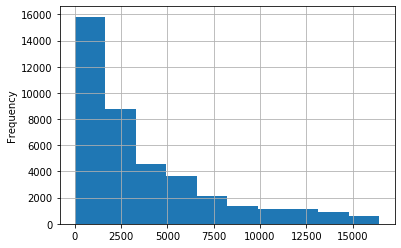

In [77]:
df['Ranking'].plot(kind = 'hist', grid = True)

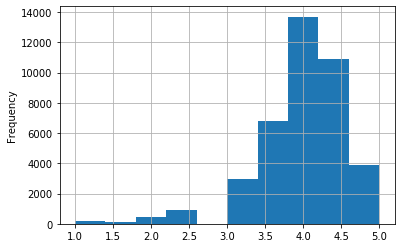

In [78]:
df['Rating'].plot(kind = 'hist', grid = True)

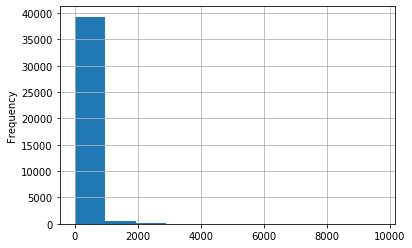

In [79]:
df['Number of Reviews'].plot(kind = 'hist', grid = True)

In [97]:
limits('Number of Reviews')

# в теории, вероятность того, что у ресторана около 10000 отзывов, далеко не равно нулю
# поэтому будем считать что выбросов нет

25-й квантиль: 10.0, 75-й квантиль: 105.0, IQR: 95.0,  Границы выбросов: [-132.5, 247.5].


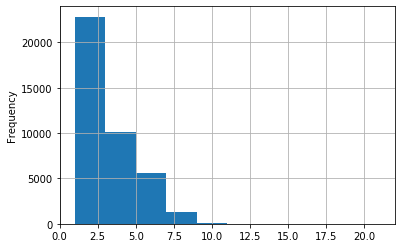

In [100]:
df['cuisines_amount'].plot(kind = 'hist', grid = True)

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [133]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop(['Rating','Ratio'], axis = 1)
y = df['Rating']

In [134]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [135]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [136]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [137]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [138]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.21222699999999994


In [120]:
df

,Ranking,Rating,Number of Reviews,more_then_mean_cuisines,cuisines_amount,Popular Cousine,date_diff,Scince_last_review,Amount_of_rests,Ratio,$,$$ - $$$,$$$$
0,5570.0,3.5,194.0,1,3,1,41.0,1072.0,4897,1.137431,0,1,0
1,1537.0,4.0,10.0,2,1,0,382.0,1250.0,820,1.874390,0,1,0
2,353.0,4.5,688.0,1,7,1,2.0,1064.0,5757,0.061317,0,0,1
3,3458.0,5.0,3.0,2,1,0,0.0,100000.0,2155,1.604640,0,1,0
4,621.0,4.0,84.0,1,3,1,272.0,1115.0,893,0.695409,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,500.0,4.5,79.0,1,4,1,34.0,1087.0,2133,0.234412,0,1,0
39996,6341.0,3.5,542.0,1,5,1,9.0,1082.0,4897,1.294874,0,1,0
39997,1652.0,4.5,4.0,0,2,0,3127.0,1495.0,820,2.014634,0,1,0
39998,641.0,4.0,70.0,1,5,1,23.0,1245.0,727,0.881706,0,1,0
